            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symptom_14 Symptom_15  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   

  Symptom_16 Symptom_17  
0        NaN        NaN  
1        NaN        NaN  
2  

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.

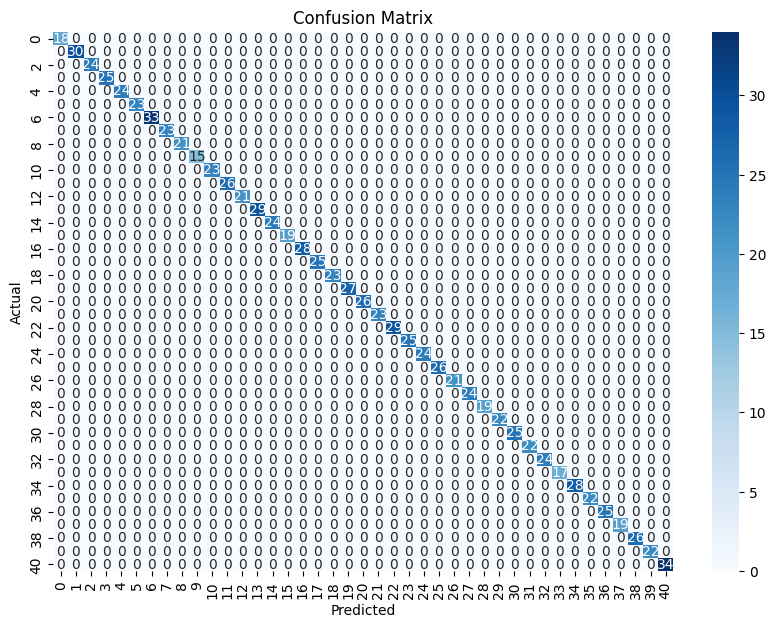

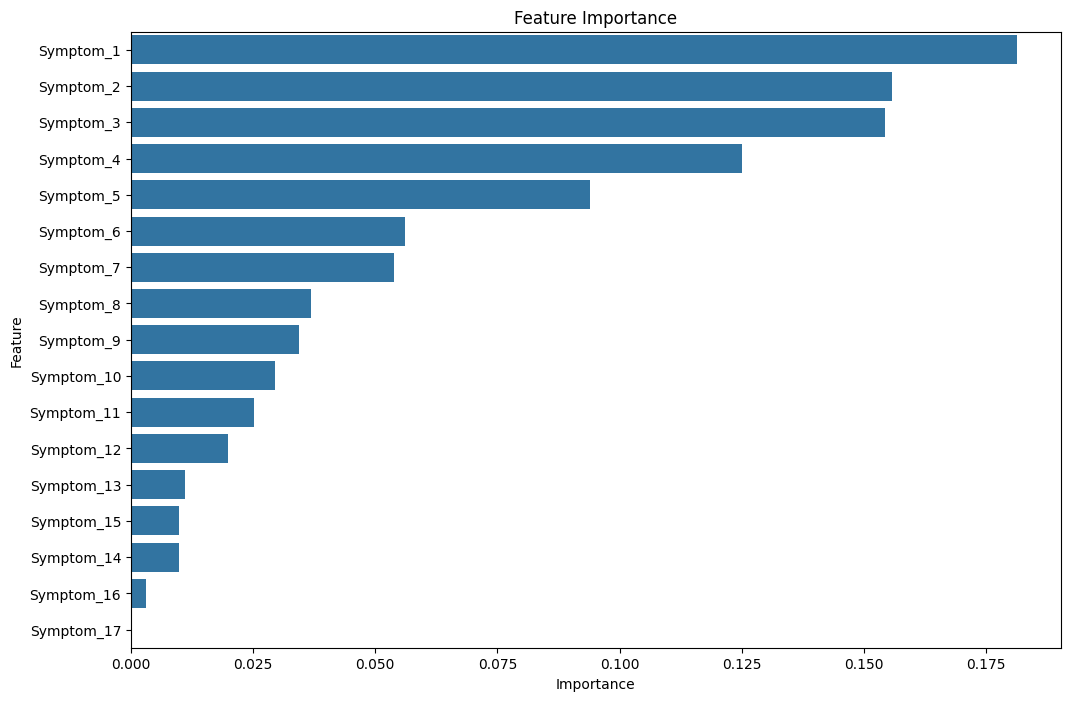

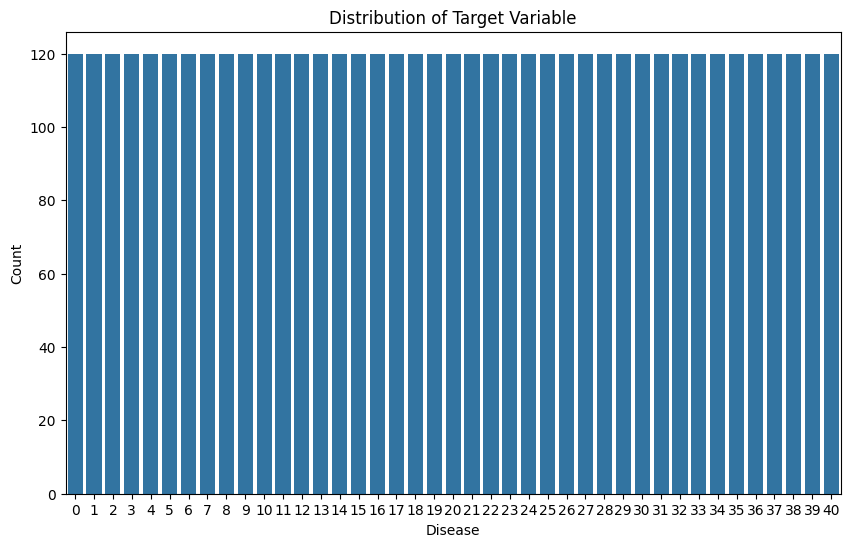

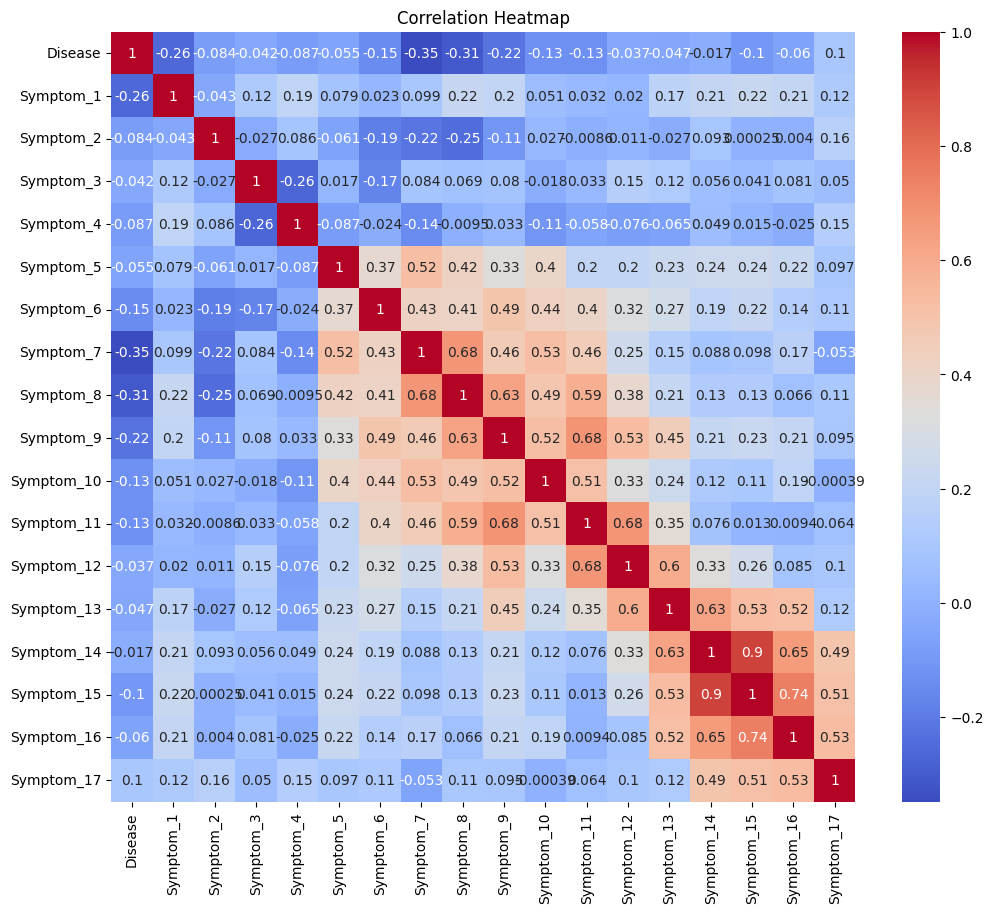

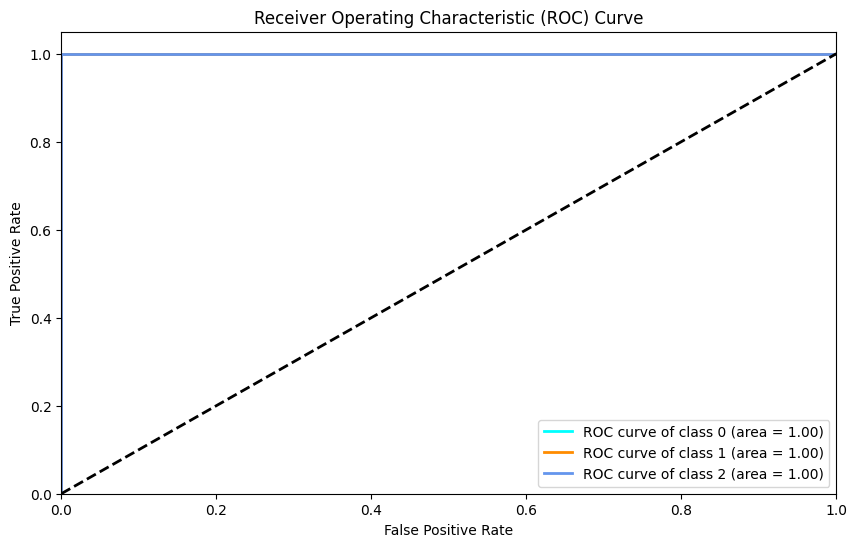

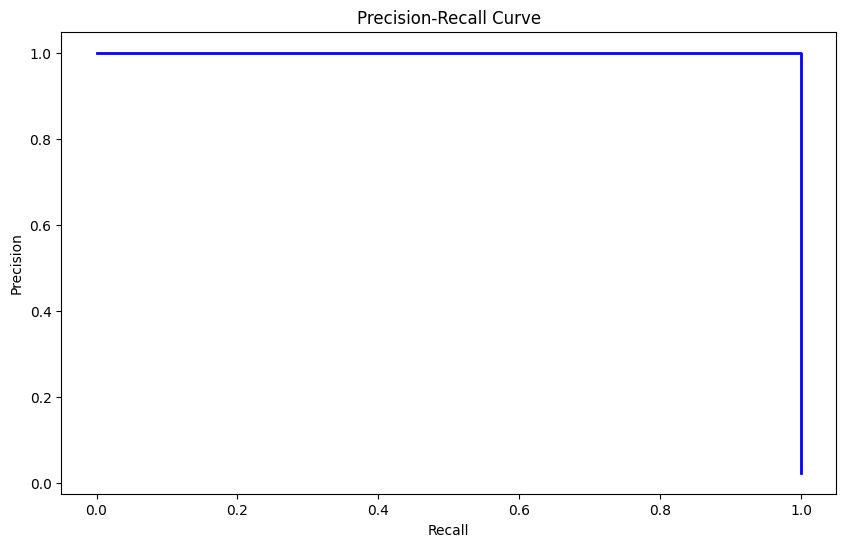

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import cycle

# Load the dataset
dataset = pd.read_csv('/content/sample_data/dataset.csv')
print(dataset.head(3))
print(dataset.columns)

# Fill missing values and encode categorical variables
dataset.fillna("unknown", inplace=True)

# Encode categorical variables
label_encoders = {}
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        label_encoders[column] = le

# Print out the classes for each label encoder
for column, le in label_encoders.items():
    print(f"Classes for column '{column}': {le.classes_}")

# Select features (X) and target (y)
X = dataset.drop('Disease', axis=1)  # Assuming 'Disease' is the target column
y = dataset['Disease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Additional Plots

# Distribution of Target Variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Disease', data=dataset)
plt.title('Distribution of Target Variable')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Binarize the output for ROC Curve
from sklearn.preprocessing import label_binarize

# Replace the actual class labels in the below line
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Learn to predict each class against the other
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train_binarized)

# Get the prediction probabilities
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for the multiclass problem
plt.figure(figsize=(10, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_binarized.ravel(), y_score.ravel())

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Save the model for future use
joblib.dump(best_model, 'disease_predictor_model.pkl')

# Function to predict disease based on symptoms
def predict_disease(symptoms):
    # Load the model
    model = joblib.load('disease_predictor_model.pkl')

    # Prepare the symptoms DataFrame
    symptoms_df = pd.DataFrame([symptoms])

    # Ensure all features are present in the DataFrame
    for column in X.columns:
        if column not in symptoms_df.columns:
            symptoms_df[column] = 'unknown'

    # Encode the symptoms using the label encoders
    for column in X.columns:
        if column in label_encoders:
            le = label_encoders[column]
            value = symptoms_df[column].iloc[0]
            if value in le.classes_:
                symptoms_df[column] = le.transform([value])[0]
            else:
                print(f"Warning: Unrecognized value '{value}' for column '{column}'.")
                # Optional: Skip encoding or handle as needed
                symptoms_df[column] = le.transform([le.classes_[0]])[0]  # Use a default value if needed

    # Predict the disease
    prediction = model.predict(symptoms_df)
    disease = label_encoders['Disease'].inverse_transform(prediction)
    return disease[0]
